Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [213]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [214]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [215]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r"Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path(r"Skin cancer ISIC The International Skin Imaging Collaboration\Test")

In [216]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Defining some parameters for the loader:

In [217]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [218]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [219]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [220]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the data

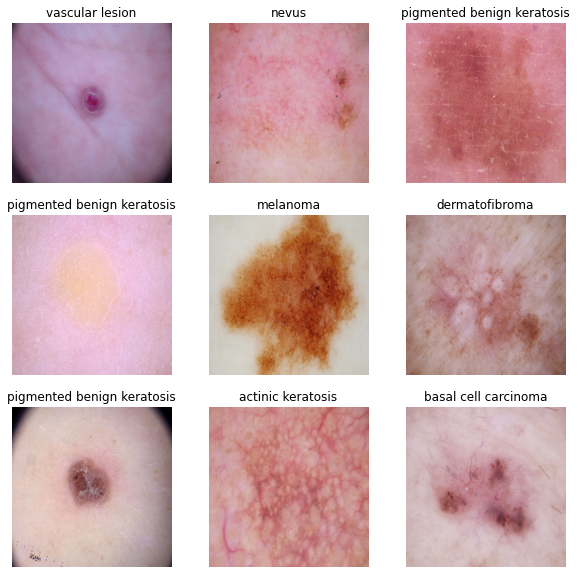

In [221]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [222]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model
Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [223]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compiling the model
Choose an appropirate optimiser and loss function for model training 

In [224]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [225]:
# View the summary of all layers
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_16 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 22, 22, 64)      

### Training the model

In [226]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 28s 402ms/step - loss: 1.9937 - accuracy: 0.2651 - val_loss: 1.7181 - val_accuracy: 0.4407
Epoch 2/20
56/56 [==============================] - 22s 389ms/step - loss: 1.6267 - accuracy: 0.4124 - val_loss: 1.5865 - val_accuracy: 0.4295
Epoch 3/20
56/56 [==============================] - 21s 378ms/step - loss: 1.4485 - accuracy: 0.4860 - val_loss: 1.4204 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 22s 391ms/step - loss: 1.3651 - accuracy: 0.5184 - val_loss: 1.3913 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 21s 377ms/step - loss: 1.2641 - accuracy: 0.5396 - val_loss: 1.3957 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 21s 378ms/step - loss: 1.1883 - accuracy: 0.5792 - val_loss: 1.5191 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 21s 378ms/step - loss: 1.1650 - accuracy: 0.5809 - val_loss: 1.4289 - val_accuracy: 0.5526

### Visualizing training results

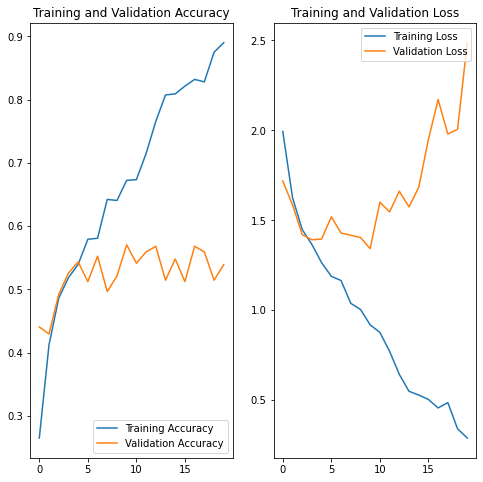

In [227]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The model is clearly OVERFITING

- #### Training Accuracy ~ 89%
- #### Validation Accuracy ~ 53%

As we can see that the training accuracy is increasing after every epoch and goes up to 91% but the validation accuracy gets stuck arround 53% after a few epoch. To deal with this problem we will. 

- #### Introduce a new augumentation layer which will do following
    - Random Rotation
    - Random Flipping
    - Random Zooming
- #### Use dropouts 

In [228]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomRotation(1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height, img_width,3))
  ]
)

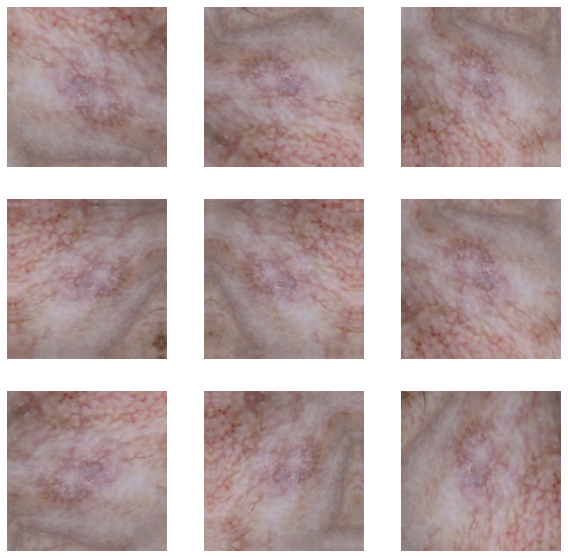

In [229]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [230]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [231]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [232]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 34s 573ms/step - loss: 2.0455 - accuracy: 0.2310 - val_loss: 1.9159 - val_accuracy: 0.2908
Epoch 2/20
56/56 [==============================] - 32s 571ms/step - loss: 1.8082 - accuracy: 0.3404 - val_loss: 1.8727 - val_accuracy: 0.3289
Epoch 3/20
56/56 [==============================] - 34s 600ms/step - loss: 1.7190 - accuracy: 0.3817 - val_loss: 1.7670 - val_accuracy: 0.3758
Epoch 4/20
56/56 [==============================] - 34s 614ms/step - loss: 1.6651 - accuracy: 0.3906 - val_loss: 1.5959 - val_accuracy: 0.4519
Epoch 5/20
56/56 [==============================] - 33s 598ms/step - loss: 1.6098 - accuracy: 0.4146 - val_loss: 1.5974 - val_accuracy: 0.4609
Epoch 6/20
56/56 [==============================] - 32s 571ms/step - loss: 1.5971 - accuracy: 0.4247 - val_loss: 1.6374 - val_accuracy: 0.4206
Epoch 7/20
56/56 [==============================] - 32s 564ms/step - loss: 1.4732 - accuracy: 0.4805 - val_loss: 1.5597 - val_accuracy: 0.4452

### Visualizing the results

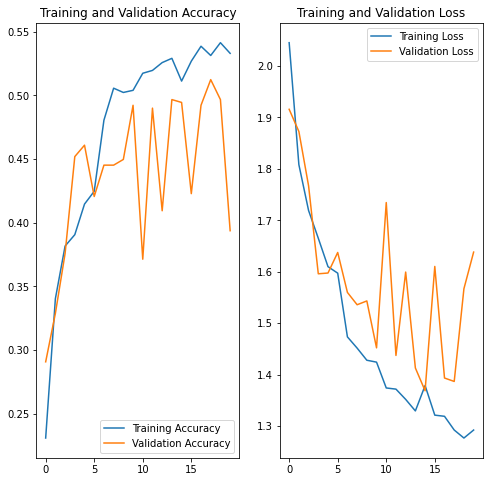

In [233]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The model is UNDERFITING

- #### Training Accuracy ~ 52%
- #### Validation Accuracy ~ 46%

The gap between training and testing accuracy has decreased but the overall accuracy of the model did not improve. We will check for class imballance in the dataset.  

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

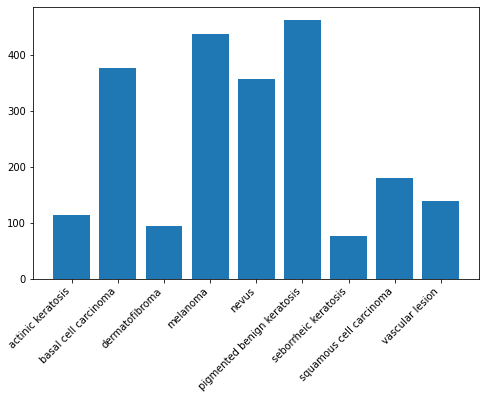

In [234]:
plt.figure(figsize=(8, 5))
plt.xticks(rotation=45, ha="right")
plt.bar(x=class_names,height=[len(list(data_dir_train.glob(c+'/*.jpg'))) for c in class_names])

#### We can see that the dataset is highly imballanced.
#### - Class "Pigmented Benign Keratosis" has the highest number of sample images
#### - Class "Seborrheic Keratosis" has the lowest number of sample images


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [235]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [236]:
path_to_training_dataset= r"Skin cancer ISIC The International Skin Imaging Collaboration\Train\\"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20FDA7F7D30>: 100%|█| 500/500 [00:04<00:00, 103.92 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20FDA906940>: 100%|█| 500/500 [00:05<00:00, 99.86 Samples/
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20FDA9AE4C0>:   0%|         | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x20FA2297FD0>: 100%|█| 500/500 [00:05<00:
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x20F8958E520>: 100%|█| 500/500 [00:25<0
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x20F9C174AC0>: 100%|█| 500/500 [00:21<00:00, 22.80 Sample
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20F86E5CD90>:   3%| | 16/500 [00:00<00:26, 18.05 Samples/s

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20FA3EC0310>: 100%|█| 500/500 [00:04<00:00, 110.59 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x20FD926C430>: 100%|█| 500/500 [00:10<00:00, 48.41 Samples
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x20F9F556490>:   2%| | 8/500 [00:00<00:26

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20F9862EDC0>: 100%|█| 500/500 [00:04<00:00, 114.77 Samples
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20F9F25B880>:   0%| | 1/500 [00:00<01:25,  5.83 Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20FA0E09B80>: 100%|█| 500/500 [00:04<00:00, 109.22 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [237]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [238]:
# path_list = [x for x in data_dir_train.glob(os.path.join('*','output', '*.jpg'))]
# path_list_new = path_list

In [239]:
# lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob(os.path.join('*','output', '*.jpg'))]
# lesion_list_new

In [240]:
# dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [241]:
# df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [242]:
# new_df['Label'].value_counts()

<BarContainer object of 9 artists>

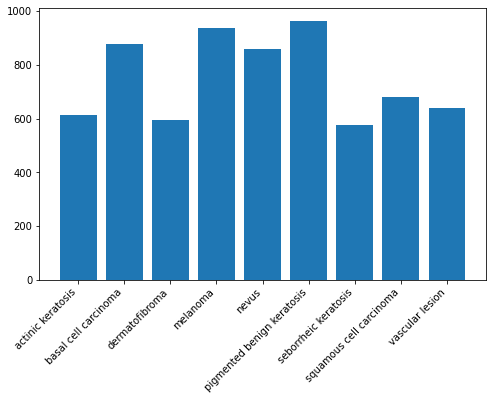

In [243]:
plt.figure(figsize=(8, 5))
plt.xticks(rotation=45, ha="right")
plt.bar(x=class_names,height=[len(list(data_dir_train.glob(c+'/*.jpg'))) + len(list(data_dir_train.glob(c+'/output/*.jpg'))) for c in class_names])

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [244]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [245]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [246]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [247]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [248]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [249]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 106s 617ms/step - loss: 2.0144 - accuracy: 0.2120 - val_loss: 1.9336 - val_accuracy: 0.3170
Epoch 2/30
169/169 [==============================] - 98s 575ms/step - loss: 1.7341 - accuracy: 0.3388 - val_loss: 1.7268 - val_accuracy: 0.3682
Epoch 3/30
169/169 [==============================] - 99s 585ms/step - loss: 1.5227 - accuracy: 0.4201 - val_loss: 1.5581 - val_accuracy: 0.4016
Epoch 4/30
169/169 [==============================] - 97s 571ms/step - loss: 1.4630 - accuracy: 0.4425 - val_loss: 1.4459 - val_accuracy: 0.4402
Epoch 5/30
169/169 [==============================] - 100s 591ms/step - loss: 1.3049 - accuracy: 0.4959 - val_loss: 1.4026 - val_accuracy: 0.4454
Epoch 6/30
169/169 [==============================] - 96s 565ms/step - loss: 1.2468 - accuracy: 0.5245 - val_loss: 1.2513 - val_accuracy: 0.5108
Epoch 7/30
169/169 [==============================] - 100s 587ms/step - loss: 1.1454 - accuracy: 0.5645 - val_loss: 1.4298 - val

#### **Todo:**  Visualize the model results

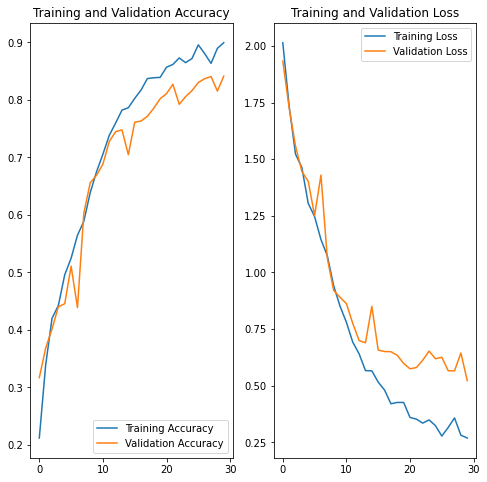

In [250]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


### This looks like a GOODFIT

- #### Training Accuracy ~ 87%
- #### Validation Accuracy ~ 85%

After performing augumentation, both training as well as the validation accuracies improved significantly. and we have a model with decent accuracy.